In [1]:
import casatools
import casatasks
import matplotlib.pyplot as plt
from eDisk_source_dict import source_dict
from visfit import load_ms
from visibility import Visibility
import numpy as np
from qdisk.classes import FitsImage
from qdisk.plot import Map
from galario.double import get_image_size
%matplotlib widget
%load_ext autoreload
%autoreload 2

pi = np.pi
deg = pi / 180.0  # in rad
arcsec = pi / 180.0 / 3600.0  # in rad

source = "L1489IRS"
PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]
center_coord = source_dict[source]["radec"]
ms = casatools.ms()
tb = casatools.table()

path = "/works/yamato/eDisk/L1489IRS/eDisk_calibrated_data/"

In [8]:
### check ``get_image_size'' function
vis = Visibility("./visibility/L1489IRS_continuum_shift.split.bin_30s.npz")
nxy, dxy = get_image_size(vis.u, vis.v, verbose=True, f_max=2.0, f_min=2.0)

dxy:6.607305e-03arcsec	nxy_MRS:4096
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:2.0 and MRS:1.353176e+01arcsec


In [40]:
def set_grid(u, v, rmax, verbose=True):
    # gridding parameter
    # print(np.min(np.sqrt(u**2+v**2)))
    nxy, dxy = get_image_size(u, v, verbose=verbose, f_min=3)  # in rad
    # print(nxy, dxy/arcsec)

    # condition for GALARIO interpolation: dxy/2 - Rmin > 5 * dR
    # not to make dR too small, adopt dxy/2/1000 as Rmin
    rmin = dxy / 2.0 * 1e-3  # in rad
    # print(rmin/arcsec)
    # dR = (dxy/2 - Rmin) / 5.0001
    dr = (dxy / 2.0 - rmin) / 5.0001  # in rad
    # dr = 0.01*arcsec
    # print(dr/arcsec)

    r_pad = 2 * dxy  # padding parameter
    rmax = dxy * nxy / np.sqrt(2) + r_pad if rmax is None else rmax # in rad
    # rmax = 10*arcsec
    # print(rmax/arcsec)

    # radial grid on image plane
    r = np.arange(rmin, rmax, dr)  # in rad

    return nxy, dxy, r, rmin, dr


data = np.load("./visibility/L1489IRS_continuum_shift.split.bin_30s.npz")
u = data["u"]
v = data["v"]
nxy, dxy, r, rmin, dr = set_grid(u, v, rmax=None)

dxy:4.955479e-03arcsec	nxy_MRS:8192
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:3 and MRS:1.353176e+01arcsec


In [3]:
get_image_size(u, v, verbose=True)

dxy:4.129566e-03arcsec	nxy_MRS:16384
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:5.0 and MRS:1.353176e+01arcsec


(16384, 2.002069871849384e-08)

In [4]:
from analysis_utils import FWHM_to_sigma

modelimagename = (
    "./fit/L1489IRS_SBLB_continuum_robust_1.0.image.tt0.imfit_doubleGaussian.model.fits"
)
image = FitsImage(modelimagename)
image.shift_phasecenter_toward(center_coord)
# r, I, dI = image.radial_profile(PA=PA, incl=incl, wedge_angle=45, rmax=7, rbins=r/arcsec, assume_correlated=False)
r, theta = image.get_disk_coord(PA=PA, incl=incl)
imfit_params = {
    "I_c": 5.052e-3 / image.Omega_beam_str * (image.dpix*arcsec)**2,
    "sigma_c_major": FWHM_to_sigma(37.2e-3),
    "sigma_c_minor": FWHM_to_sigma(23.5e-3),
    "pa_c": 177.4,
    "I_b": 134.2e-6 / image.Omega_beam_str * (image.dpix*arcsec)**2,
    "sigma_b_major": FWHM_to_sigma(3.889),
    "sigma_b_minor": FWHM_to_sigma(1.274),
    "pa_b": 65.79
}


x, y = image.get_disk_coord(PA=imfit_params["pa_c"], incl=0.0, frame="cartesian")
model = imfit_params["I_c"] * np.exp(- x**2/(2*imfit_params["sigma_c_major"]**2) - y**2/(2*imfit_params["sigma_c_minor"]**2))
x, y = image.get_disk_coord(PA=imfit_params["pa_b"], incl=0.0, frame="cartesian")
model += imfit_params["I_b"] * np.exp(- x**2/(2*imfit_params["sigma_b_major"]**2) - y**2/(2*imfit_params["sigma_b_minor"]**2))


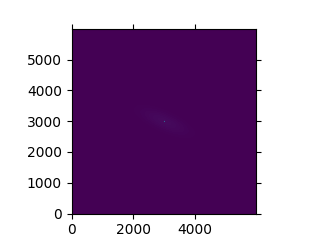

In [5]:
plt.figure()
plt.imshow(model, origin="lower")

In [6]:
from galario.double import sampleImage

V = sampleImage(image=model.astype("float64"), dxy=image.dpix*arcsec, u=u, v=v, dRA=0.0, dDec=0.0, PA=PA)

In [49]:
np.savez("./L1489IRS_continuum_shift.bin_30s.doubleGaussianImfit.npz", u=u, v=v, V=V, weight=data["weight"])

In [50]:
modelvis = Visibility("./L1489IRS_continuum_shift.bin_30s.doubleGaussianImfit.npz")
uv, V, Verr = modelvis.bin_1D()

/home/yamato/Project/eDisk/firstlook_L1489IRS/.venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


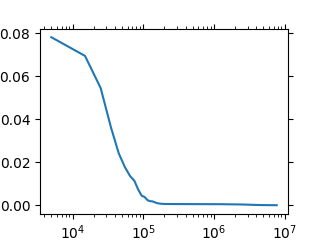

In [51]:
plt.figure()
plt.plot(uv, V)
plt.xscale("log")
# plt.yscale("log")

In [52]:
np.savez("./L1489IRS_continuum_shift.bin_30s.doubleGaussianImfit.uvprofile.npz", uvdist=uv, V=V, Verr=Verr)

In [41]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

from qdisk.classes import FitsImage
from qdisk.plot import Map
from mcmc_tools import EmceeHammer
from eDisk_source_dict import source_dict
import numpy as np
import matplotlib.pyplot as plt

source = "L1489IRS"
center_coord = source_dict[source]["radec"]

def setup_params(param_dict):

    param_name = [
        key for key in param_dict.keys() if not param_dict[key]["fixed"]
    ]
    fixed_param_name = [
        key for key in param_dict.keys() if param_dict[key]["fixed"]
    ]
    bound = [
        param_dict[key]["bound"]
        for key in param_dict.keys()
        if not param_dict[key]["fixed"]
    ]
    initial_state = [
        param_dict[key]["p0"]
        for key in param_dict.keys()
        if not param_dict[key]["fixed"]
    ]

    return param_name, fixed_param_name, bound, initial_state

param_dict_init = {
    # "I_g": {"p0": 8.5, "bound": (-2.0, 20.0), "fixed": False},
    # "sigma_g": {"p0": 2.0, "bound": (0.1, 10), "fixed": False},
    "F_c": {"p0": 10.538, "bound": (5, 15), "fixed": False},
    "sigma_c": {"p0": 0.007, "bound": (1e-5, 0.2), "fixed": False},
    "r0_r": {"p0": 0.2, "bound": (0.2, 0.7), "fixed": False},
    "F_r": {"p0": 8.327, "bound": (3, 13), "fixed": False},
    "sigma_r": {"p0": 0.204, "bound": (1e-2, 1.5), "fixed": False},
    "F_b": {"p0": 9.112, "bound": (4, 14), "fixed": False},
    "sigma_b": {"p0": 1.548, "bound": (0.3, 5), "fixed": False},
    "PA": {"p0": 67.237, "bound": (0, 180), "fixed": False},
    "incl": {"p0": 70.556, "bound": (0, 90), "fixed": False},
    "dRA": {"p0": 0.004, "bound": (-2, 2), "fixed": False},
    "dDec": {"p0": -0.001, "bound": (-2, 2), "fixed": False},
}

# param_dict_init = {
#     # "I_g": {"p0": 8.5, "bound": (-2.0, 20.0), "fixed": False},
#     # "sigma_g": {"p0": 2.0, "bound": (0.1, 10), "fixed": False},
#     "F_c": {"p0": 10.538, "bound": (5, 15), "fixed": False},
#     "sigma_c": {"p0": 0.007, "bound": (1e-5, 0.2), "fixed": False},
#     "r0_r": {"p0": 0.2, "bound": (0.2, 0.7), "fixed": False},
#     "F_r": {"p0": 8.327, "bound": (3, 13), "fixed": False},
#     "sigma_r": {"p0": 0.204, "bound": (1e-2, 1.5), "fixed": False},
#     "F_b": {"p0": 9.112, "bound": (4, 14), "fixed": False},
#     "sigma_b": {"p0": 1.548, "bound": (0.3, 5), "fixed": False},
#     "r_1": {"p0": 1.58, "bound": (0.5, 14), "fixed": False},
#     "F_1": {"p0": 2, "bound": (0, 14), "fixed": False},
#     "sigma_1": {"p0": 0.2, "bound": (0.05, 5), "fixed": False},
#     "r_2": {"p0": 2.25, "bound": (4, 14), "fixed": False},
#     "F_2": {"p0": 2, "bound": (0, 14), "fixed": False},
#     "sigma_2": {"p0": 0.18, "bound": (0.05, 5), "fixed": False},
#     "PA": {"p0": 67.237, "bound": (0, 180), "fixed": False},
#     "incl": {"p0": 70.556, "bound": (0, 90), "fixed": False},
#     "dRA": {"p0": 0.004, "bound": (-2, 2), "fixed": False},
#     "dDec": {"p0": -0.001, "bound": (-2, 2), "fixed": False},
# }

# ring2 = GaussianRing1d(r, 1.58, -5.2, 0.2)
# ring3 = GaussianRing1d(r, 2.25, -5.5, 0.18)

param_name, fixed_param_name, bound, initial_state = setup_params(param_dict_init)

hammer = EmceeHammer()
hammer.load_backend("./L1489IRS_continuum_shift.split.bin_30s.GaussianSingleRing.h5")
MAP_params = hammer.get_MAP_params()
# param_dict = {name: param_dict_init[p]["p0"] for name, p in zip(param_name, param_dict_init)}
param_dict = {name: p for name, p in zip(param_name, MAP_params)}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
def Gaussian1d(r, F, sigma):
    return 10 ** F / (np.sqrt(2 * np.pi) * sigma) * np.exp(-r**2 / (2 * sigma**2))

def GaussianRing1d(r, r0, F, sigma):
    return 10 ** F / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(r - r0)**2 / (2 * sigma**2))

def model_func_1d(r, F_c, sigma_c, F_b, sigma_b):
    return (
        Gaussian1d(r, F_c, sigma_c)
        + Gaussian1d(r, F_b, sigma_b)
    )

In [43]:
param_dict.pop("sigma_r")
param_dict.pop("F_r")
param_dict.pop("r0_r")
PA = param_dict.pop("PA")
incl = param_dict.pop("incl")
dRA = param_dict.pop("dRA")
dDec = param_dict.pop("dDec")

In [44]:
model = model_func_1d(r/arcsec, **param_dict)

In [45]:
r.max()/arcsec

28.71493783747233

In [46]:
from galario.double import sampleProfile

V = sampleProfile(
        intensity=model.astype("float64"),
        Rmin=rmin,
        dR=dr,
        nxy=nxy,
        dxy=dxy,
        u=u,
        v=v,
        dRA=dRA*arcsec,
        dDec=dDec*arcsec,
        PA=PA * deg,
        inc=incl * deg,
        check=False,
    )

In [36]:
np.savez("./L1489IRS_continuum_shift.bin_30s.doubleGaussian.npz", u=u, v=v, V=V, weight=data["weight"])

/home/yamato/Project/eDisk/firstlook_L1489IRS/.venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


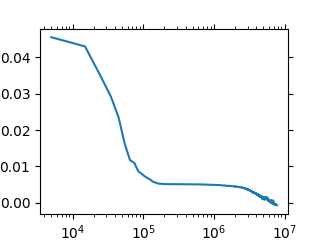

In [37]:
modelvis = Visibility("./L1489IRS_continuum_shift.bin_30s.doubleGaussian.npz")
uv, V, Verr = modelvis.bin_1D()

plt.figure()
plt.plot(uv, V)
plt.xscale("log")
# plt.yscale("log")

In [38]:
np.savez("./L1489IRS_continuum_shift.bin_30s.doubleGaussian.uvprofile.npz", uvdist=uv, V=V, Verr=Verr)

In [9]:
path = "/works/yamato/eDisk/L1489IRS/visibility_analysis/"
msfilenames = [path + "L1489IRS_{}_continuum_shift.split.ms".format(i) for i in ["SB1", "SB2", "LB1", "LB2"]]
vis_noave = Visibility(msfilenames)
vis_noave.export_vis("./visibility/L1489IRS_continuum_shift_oldDDT.split.npz")

Loading /works/yamato/eDisk/L1489IRS/visibility_analysis/L1489IRS_SB1_continuum_shift.split.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading data in spw 3...
Loading data in spw 4...
Loading data in spw 5...
Loading data in spw 6...
Loading /works/yamato/eDisk/L1489IRS/visibility_analysis/L1489IRS_SB2_continuum_shift.split.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading data in spw 3...
Loading data in spw 4...
Loading data in spw 5...
Loading data in spw 6...
Loading /works/yamato/eDisk/L1489IRS/visibility_analysis/L1489IRS_LB1_continuum_shift.split.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading data in spw 3...
Loading data in spw 4...
Loading data in spw 5...
Loading data in spw 6...
Loading /works/yamato/eDisk/L1489IRS/visibility_analysis/L1489IRS_LB2_continuum_shift.split.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading 

In [4]:
filename = "./visibility/L1489IRS_continuum_shift.split.npz"
vis = Visibility(filename)
print(vis.V.shape)
vis.deproject(PA=PA, incl=incl)
binuv, binV, binVerr = vis.bin_1D(binsize=10e3)

(16488914,)


In [5]:
filename = "./visibility/L1489IRS_continuum_shift_oldDDT.split.npz"
vis = Visibility(filename)
print(vis.V.shape)
vis.deproject(PA=PA, incl=incl)
olduv, oldV, oldVerr = vis.bin_1D(binsize=10e3)

(15231854,)


In [6]:
filename = "./L1489IRS_continuum_shift.split.bin_30s.GaussianSingleRing.bestfit.npz"
modelvis = Visibility(filename)
modelvis.deproject(PA=param_dict.get("PA"), incl=param_dict.get("incl"))
modeluv, modelV, modelerr = modelvis.bin_1D()

In [9]:
filename = "./visibility/L1489IRS_continuum_shift.split.npz"
vis = Visibility(filename)
vis.deproject(PA=PA, incl=incl)
uv, V, Verr = vis.bin_1D(binsize=50e3)

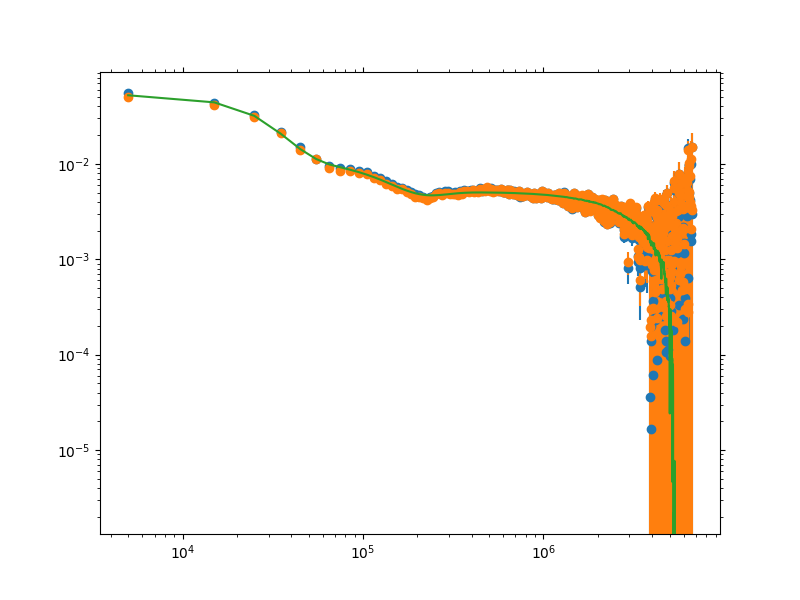

In [10]:
plt.figure(figsize=(8,6))
# plt.errorbar(uv, V.real, yerr=Verr.real, fmt="o")
plt.errorbar(binuv, binV.real, yerr=binVerr.real, fmt="o")
plt.errorbar(olduv, oldV.real, yerr=oldVerr.real, fmt="o")
plt.plot(modeluv, modelV.real, zorder=100)
# bindata = np.load("./L1489IRS_continuum_split_uvprofile.npz") 
# plt.errorbar(bindata["uvdist"], bindata["V"].real, yerr=bindata["Verr"].real, fmt="o")
plt.xscale("log")
plt.yscale("log")

In [8]:
### plot profile not preaveraging
msfilenames = [path + "L1489IRS_{:s}_continuum_shift.ms".format(i) for i in ["SB1", "SB2", "SB3", "LB1", "LB2"]]
vis = Visibility(msfilenames)
vis.bin_2D(binsize=10e3)
filename = "./visibility/L1489IRS_continuum_shift_bin_10klambda.npz"
vis.export_vis(filename)


Loading /works/yamato/eDisk/L1489IRS/ALMA_pipeline_calibrated_data/L1489IRS_SB1_continuum_shift.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading data in spw 3...
Loading data in spw 4...
Loading data in spw 5...
Loading data in spw 6...
Loading /works/yamato/eDisk/L1489IRS/ALMA_pipeline_calibrated_data/L1489IRS_SB2_continuum_shift.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading data in spw 3...
Loading data in spw 4...
Loading data in spw 5...
Loading data in spw 6...
Loading /works/yamato/eDisk/L1489IRS/ALMA_pipeline_calibrated_data/L1489IRS_SB3_continuum_shift.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading data in spw 3...
Loading data in spw 4...
Loading data in spw 5...
Loading data in spw 6...
Loading /works/yamato/eDisk/L1489IRS/ALMA_pipeline_calibrated_data/L1489IRS_LB1_continuum_shift.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in s

/home/yamato/Project/eDisk/firstlook_L1489IRS/visibility.py:53: RuntimeWarning: invalid value encountered in divide
  return vw / w


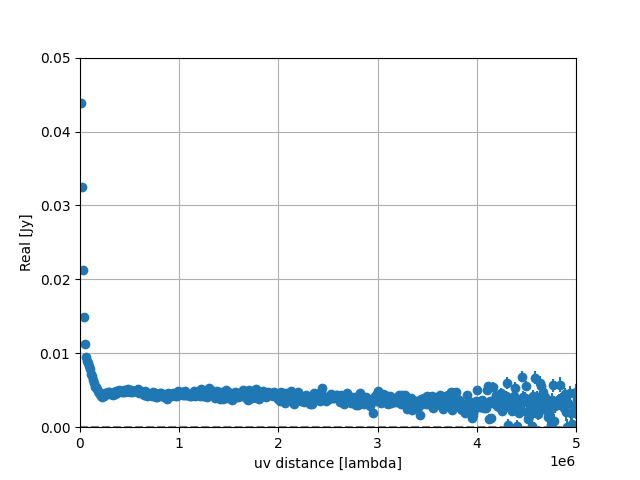

In [23]:
plt.figure()

data = np.load("./L1489IRS_continuum_uvprofile.npz")
# plt.errorbar(data["uvdist"], data["V"].real, yerr=data["Verr"].real, fmt="o")
bindata = np.load("./L1489IRS_continuum_split_uvprofile.npz") 
plt.errorbar(bindata["uvdist"], bindata["V"].real, yerr=bindata["Verr"].real, fmt="o")
plt.axhline(y=0.0, color="grey", ls="dashed")
# plt.xscale("log")
plt.xlabel("uv distance [lambda]")
plt.ylabel("Real [Jy]")
plt.ylim(-0.02, 0.06)
plt.ylim(0, 0.05)
plt.xlim(0, 5e6)
plt.grid()

In [ ]:
msfilenames = [path + "L1489IRS_{:s}_continuum_shift.split.ms".format(i) for i in ["SB1", "SB2", "SB3", "LB1", "LB2"]]
vis = Visibility(msfilenames)


In [58]:
import numpy as np
import astropy.constants as ac
import astropy.units as units

c = ac.c.to(units.m / units.s).value
pi = np.pi
deg = pi / 180.0  # in rad
arcsec = pi / 180.0 / 3600.0  # in rad



def Gaussian1d(r, F, sigma):
    return 10 ** F / (np.sqrt(2 * np.pi) * sigma) * np.exp(-r**2 / (2 * sigma**2))

def GaussianRing1d(r, r0, F, sigma):
    return 10 ** F / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(r - r0)**2 / (2 * sigma**2))

def model_func_1d(r, F_c, sigma_c, r0_r, F_r, sigma_r, F_b, sigma_b):
    return (
        Gaussian1d(r, F_c, sigma_c)
        + GaussianRing1d(r, r0_r, F_r, sigma_r)
        + Gaussian1d(r, F_b, sigma_b)
    )


# dictionary of parameters including initial guess, bound, and fixed/free
param_dict = {
    # "I_g": {"p0": 8.5, "bound": (-2.0, 20.0), "fixed": False},
    # "sigma_g": {"p0": 2.0, "bound": (0.1, 10), "fixed": False},
    "F_c": {"p0": 10.62, "bound": (5, 15), "fixed": False},
    "sigma_c": {"p0": 0.005, "bound": (1e-5, 0.2), "fixed": False},
    "r0_r": {"p0": 0.27, "bound": (0.2, 0.7), "fixed": False},
    "F_r": {"p0": 8.66, "bound": (3, 13), "fixed": False},
    "sigma_r": {"p0": 0.29, "bound": (1e-2, 1.5), "fixed": False},
    "F_b": {"p0": 9.17, "bound": (4, 14), "fixed": False},
    "sigma_b": {"p0": 1.62, "bound": (0.3, 5), "fixed": False},
    # "PA": {"p0": 68.9, "bound": (0, 180), "fixed": False},
    # "incl": {"p0": 72.86, "bound": (0, 90), "fixed": False},
    # "dRA": {"p0": 0.0, "bound": (-2, 2), "fixed": False},
    # "dDec": {"p0": 0.0, "bound": (-2, 2), "fixed": False},
}

params = {p: param_dict[p]["p0"] for p in param_dict.keys()}

from galario.double import sampleProfile, get_image_size

def set_grid(u, v, rmax, verbose=True):
    # gridding parameter
    # print(np.min(np.sqrt(u**2+v**2)))
    nxy, dxy = get_image_size(u, v, verbose=verbose, f_min=3)  # in rad
    # print(nxy, dxy/arcsec)

    # condition for GALARIO interpolation: dxy/2 - Rmin > 5 * dR
    # not to make dR too small, adopt dxy/2/1000 as Rmin
    rmin = dxy / 2.0 * 1e-3  # in rad
    # print(rmin/arcsec)
    # dR = (dxy/2 - Rmin) / 5.0001
    dr = (dxy / 2.0 - rmin) / 5.0001  # in rad
    # dr = 0.01*arcsec
    # print(dr/arcsec)

    r_pad = 2 * dxy  # padding parameter
    rmax = dxy * nxy / np.sqrt(2) + r_pad if rmax is None else rmax # in rad
    rmax = 10*arcsec
    # print(rmax/arcsec)

    # radial grid on image plane
    r = np.arange(rmin, rmax, dr)  # in rad

    return nxy, dxy, r, rmin, dr

nxy, dxy, r, rmin, dr = set_grid(vis.u, vis.v, rmax=None)

model = model_func_1d(r/arcsec, **params)

V = sampleProfile(
        intensity=model,
        Rmin=rmin,
        dR=dr,
        nxy=nxy,
        dxy=dxy,
        u=vis.u,
        v=vis.v,
        dRA=0.0,
        dDec=0.0,
        PA=PA * deg,
        inc=incl * deg,
        check=False,
    )

filename = "./test.npz"
np.savez(filename, u=vis.u, v=vis.v, V=V, weight=vis.weight)

dxy:4.957879e-03arcsec	nxy_MRS:8192
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:3 and MRS:1.353832e+01arcsec


/tmp/ipykernel_767463/553542623.py:19: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 5e6)


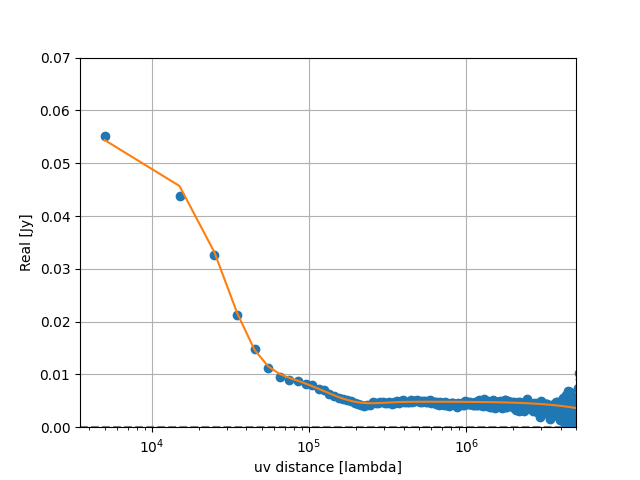

In [59]:
plt.figure()

# data = np.load("./L1489IRS_continuum_uvprofile.npz")
# plt.errorbar(data["uvdist"], data["V"].real, yerr=data["Verr"].real, fmt="o")
bindata = np.load("./L1489IRS_continuum_split_uvprofile.npz") 
plt.errorbar(bindata["uvdist"], bindata["V"].real, yerr=bindata["Verr"].real, fmt="o")

modelvis = Visibility(filename)
modelvis.deproject(PA=PA, incl=incl)
uvdist, V, Verr = modelvis.bin_1D()

plt.plot(uvdist, V.real, zorder=100)
plt.axhline(y=0.0, color="grey", ls="dashed")
plt.xscale("log")
plt.xlabel("uv distance [lambda]")
plt.ylabel("Real [Jy]")
plt.ylim(-0.02, 0.06)
plt.ylim(0, 0.07)
plt.xlim(0, 5e6)
plt.grid()

In [67]:
vis.deproject(PA=PA, incl=incl)
uv, v, err = vis.bin_1D(binsize=10e3)

KeyboardInterrupt: 

In [64]:
modelvis = Visibility(filename)
modelvis.deproject(PA=PA, incl=incl)
modeluv, modelv, modelerr = modelvis.bin_1D(binsize=10e3)

(-0.02, 0.06)

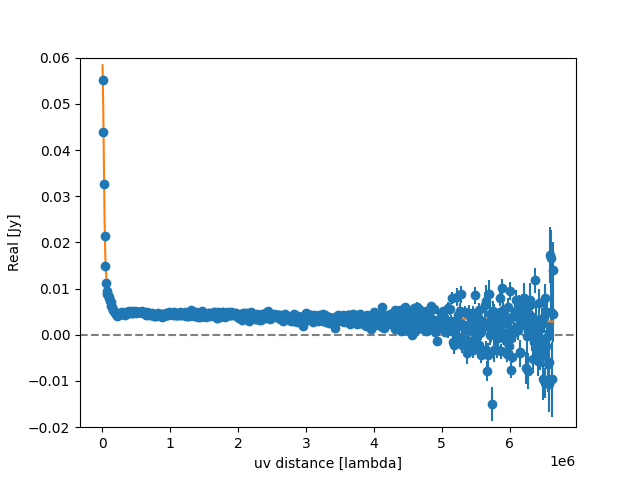

In [65]:
plt.figure()
plt.errorbar(uv, v.real, yerr=err, fmt="o")
plt.plot(modeluv, modelv.real)
plt.axhline(y=0.0, color="grey", ls="dashed")
# plt.xscale("log")
plt.xlabel("uv distance [lambda]")
plt.ylabel("Real [Jy]")
plt.ylim(-0.02, 0.06)


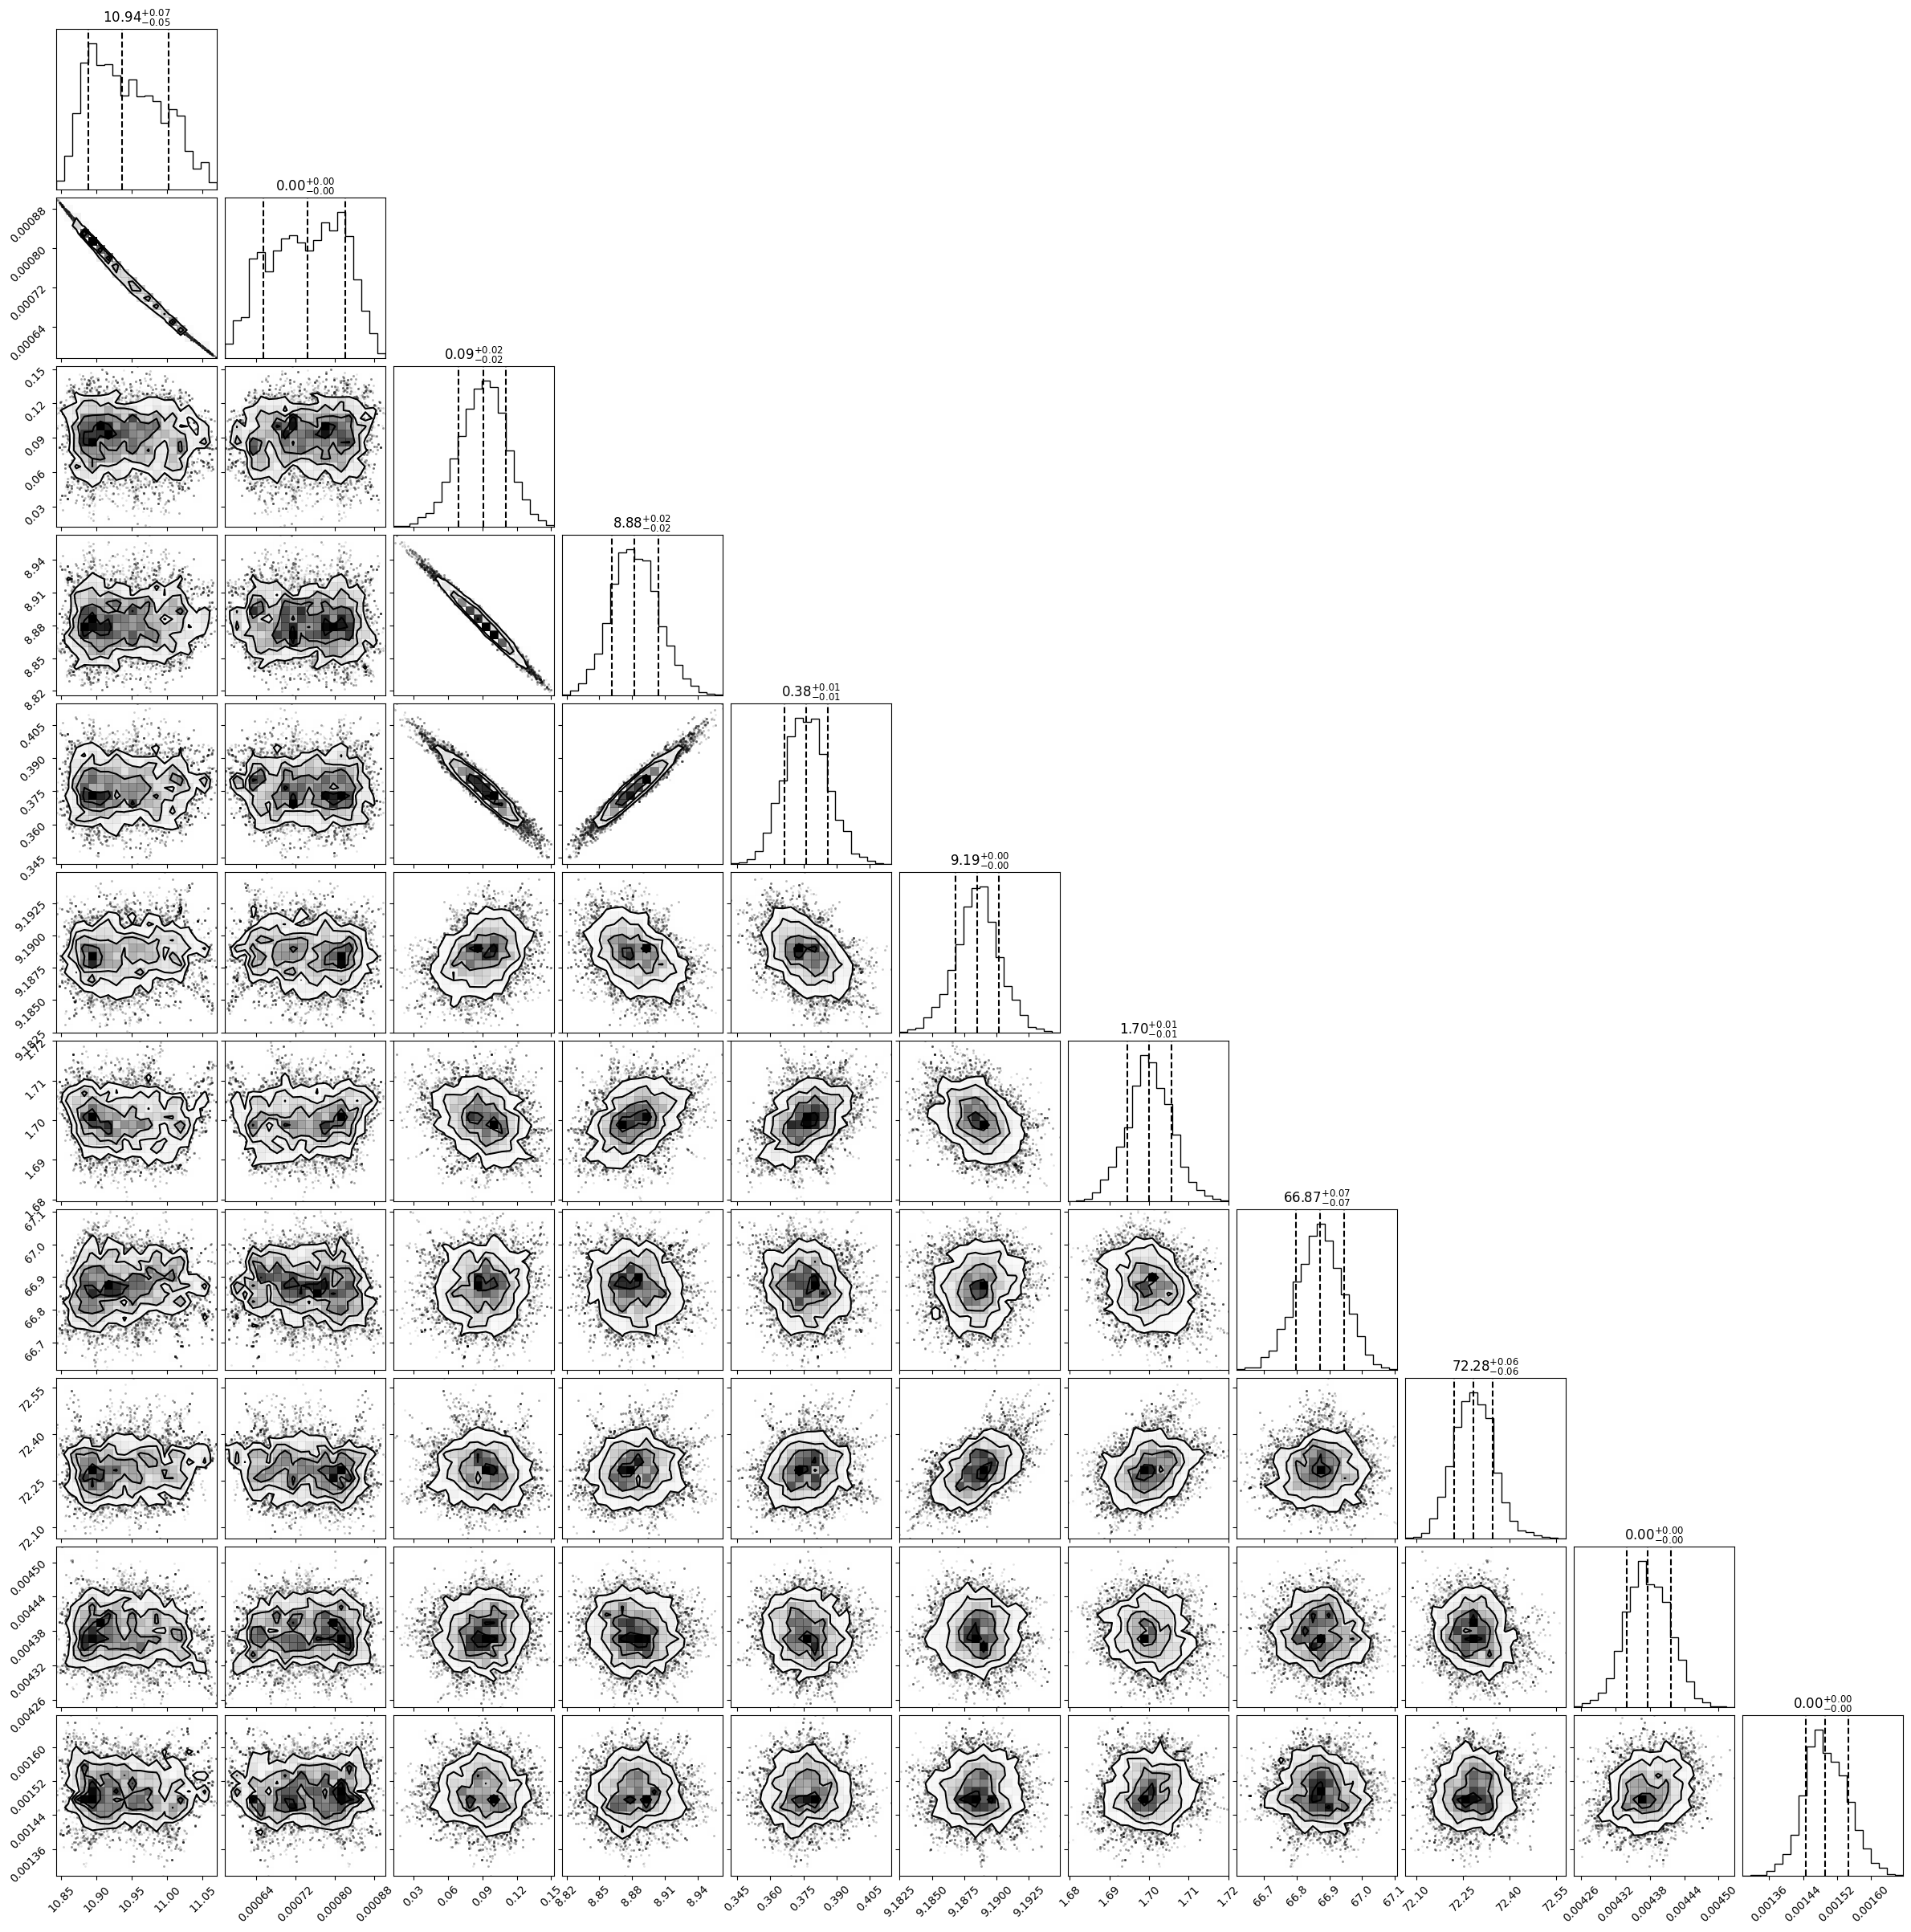

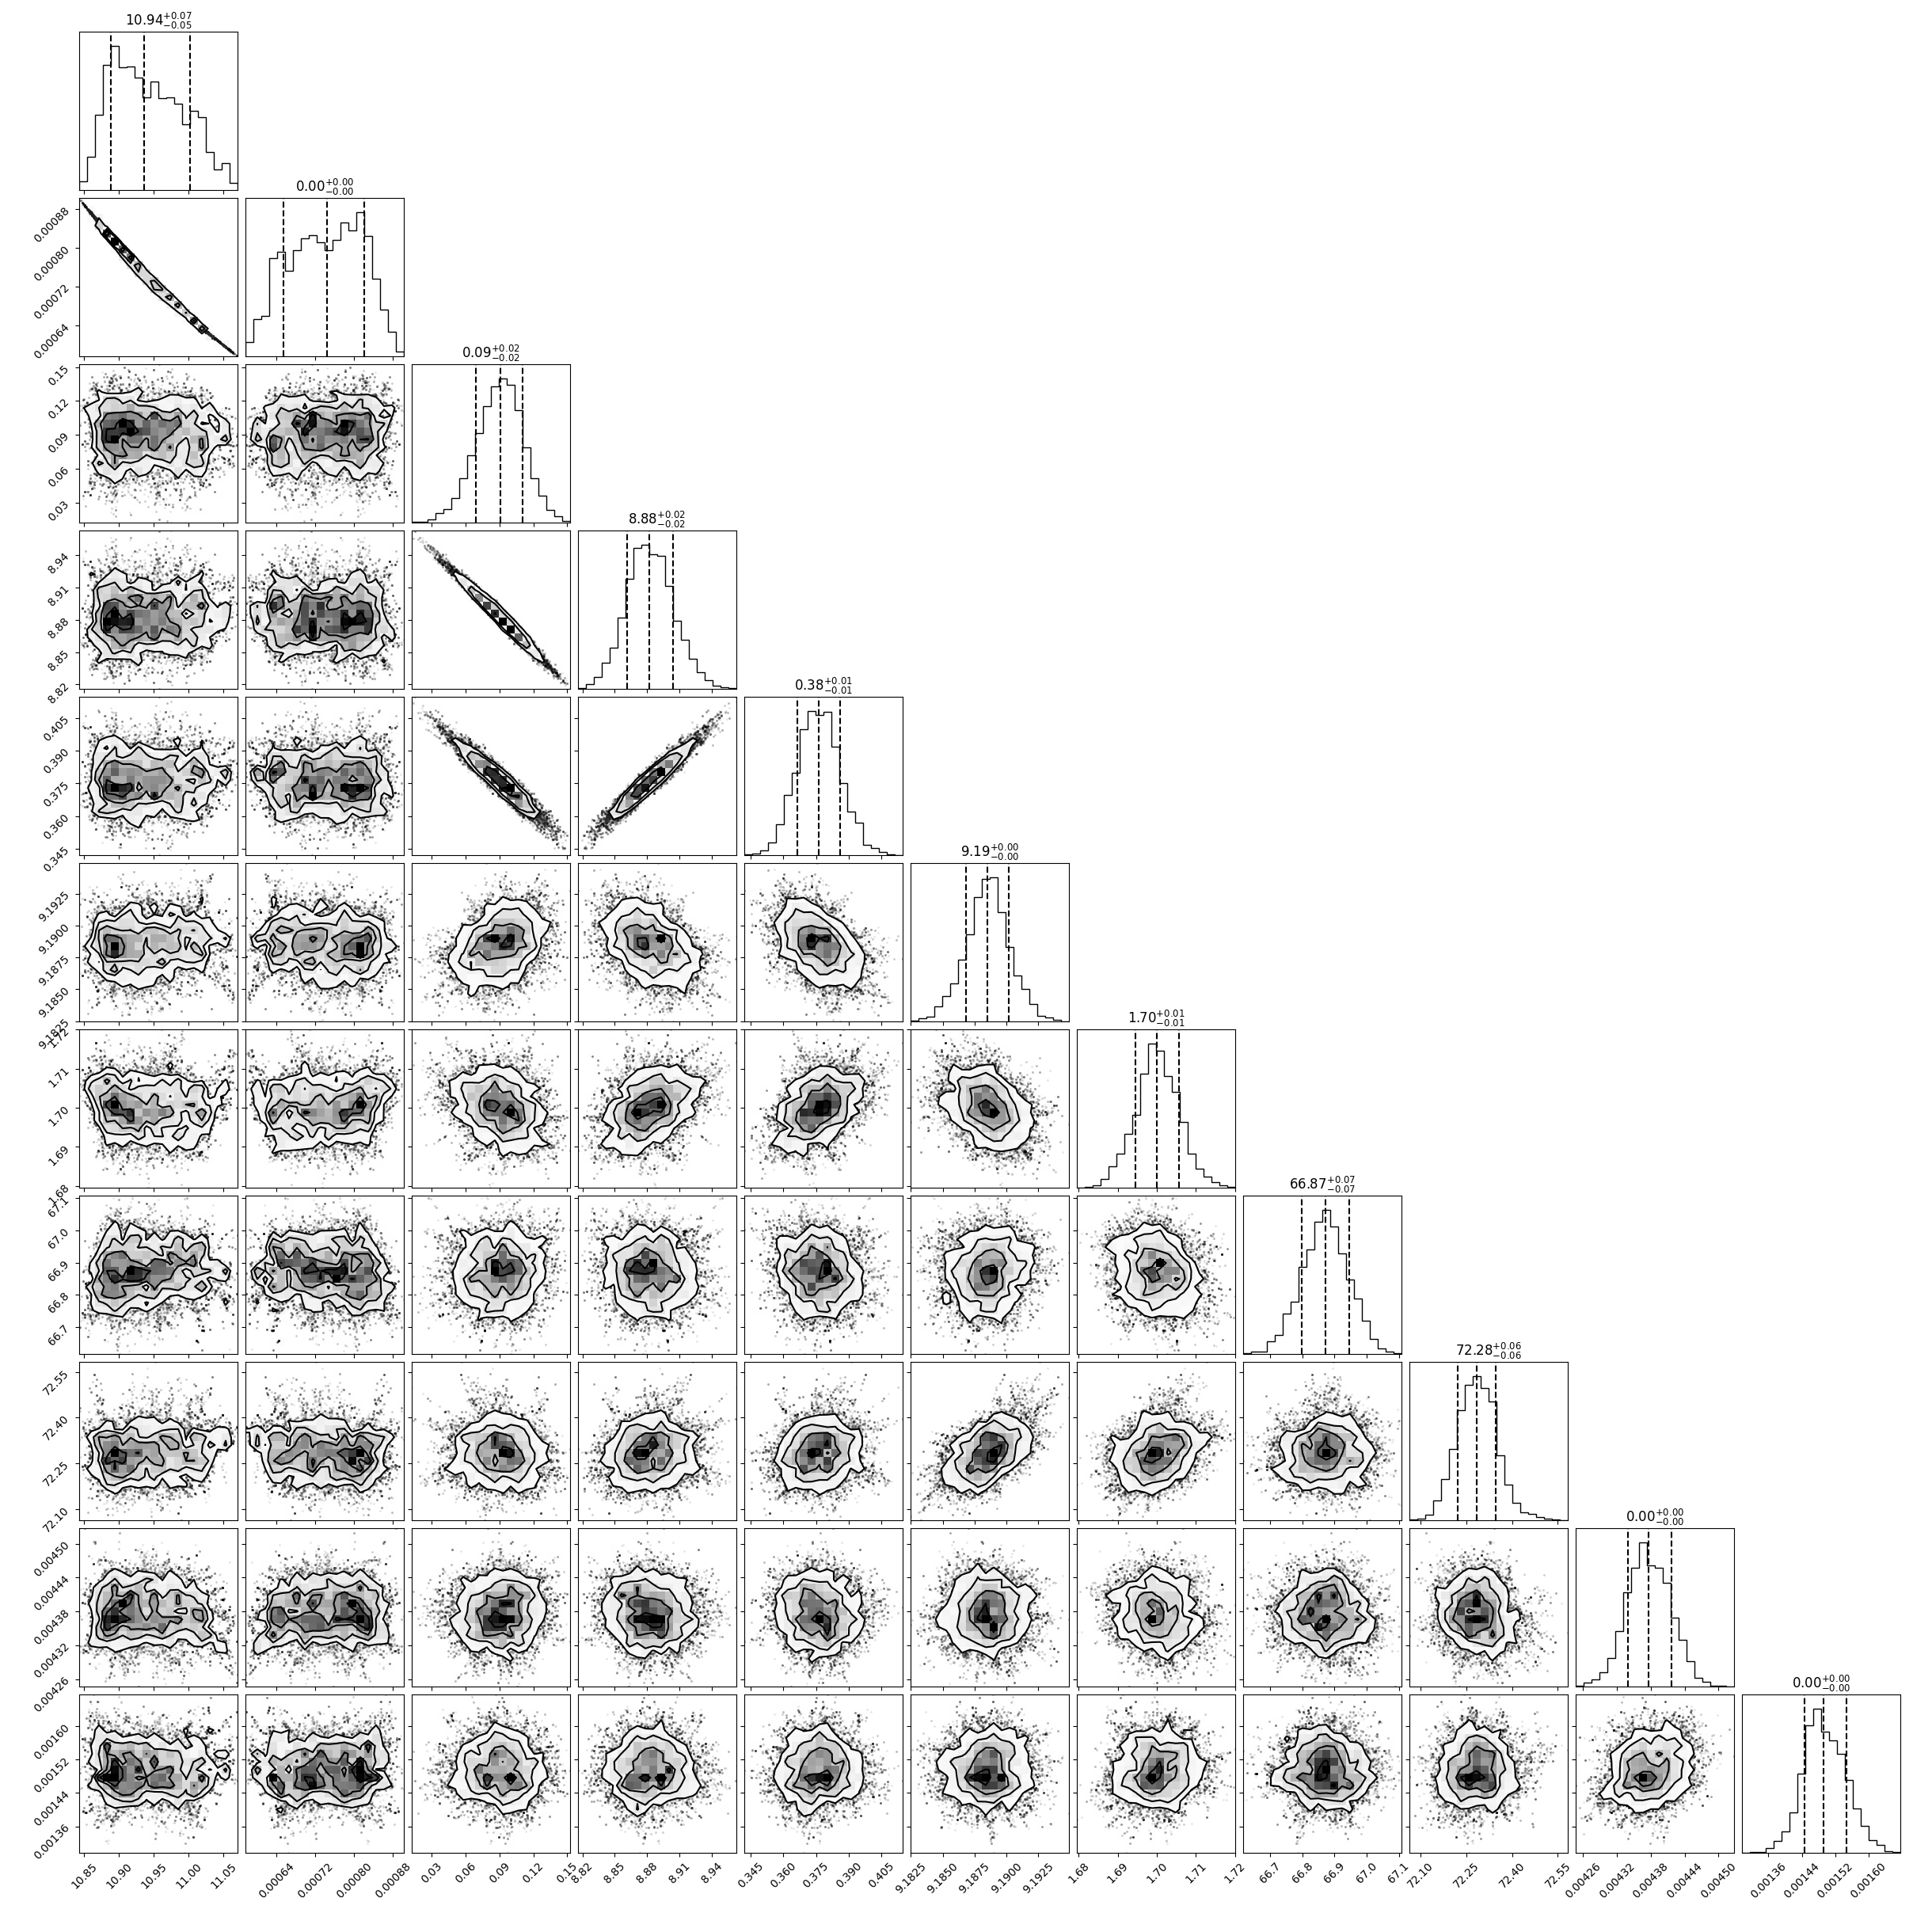

In [22]:
### plot mcmc fit
from mcmc_tools import EmceeHammer

hammer = EmceeHammer()
hammer.load_backend("L1489IRS_singleRing.h5")
hammer.plot_corner(nburnin=4000)


In [31]:
import numpy as np

def Gaussian1d(r, F, sigma):
    return 10 ** F / (np.sqrt(2 * np.pi) * sigma) * np.exp(-r**2 / (2 * sigma**2))

def GaussianRing1d(r, r0, F, sigma):
    return 10 ** F / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(r - r0)**2 / (2 * sigma**2))


def model_func_1d(r, F_c, sigma_c, r0_r, F_r, sigma_r, F_b, sigma_b):
    return (
        Gaussian1d(r, F_c, sigma_c)
        + GaussianRing1d(r, r0_r, F_r, sigma_r)
        + Gaussian1d(r, F_b, sigma_b)
    )


# dictionary of parameters including initial guess, bound, and fixed/free
param_dict = {
    # "I_g": {"p0": 8.5, "bound": (-2.0, 20.0), "fixed": False},
    # "sigma_g": {"p0": 2.0, "bound": (0.1, 10), "fixed": False},
    "F_c": {"p0": 10.59, "bound": (5, 15), "fixed": False},
    "sigma_c": {"p0": 0.01, "bound": (1e-5, 0.2), "fixed": False},
    "r0_r": {"p0": 0.47, "bound": (0.01, 1.5), "fixed": False},
    "F_r": {"p0": 8.31, "bound": (3, 13), "fixed": False},
    "sigma_r": {"p0": 0.20, "bound": (1e-2, 1.5), "fixed": False},
    "F_b": {"p0": 9.14, "bound": (4, 14), "fixed": False},
    "sigma_b": {"p0": 1.59, "bound": (0.3, 5), "fixed": False},
    "PA": {"p0": 68.9, "bound": (0, 180), "fixed": False},
    "incl": {"p0": 72.86, "bound": (0, 90), "fixed": False},
    "dRA": {"p0": 0.0, "bound": (-2, 2), "fixed": False},
    "dDec": {"p0": 0.0, "bound": (-2, 2), "fixed": False},
}

def setup_params(param_dict):

    param_name = [
        key for key in param_dict.keys() if not param_dict[key]["fixed"]
    ]
    fixed_param_name = [
        key for key in param_dict.keys() if param_dict[key]["fixed"]
    ]
    bound = [
        param_dict[key]["bound"]
        for key in param_dict.keys()
        if not param_dict[key]["fixed"]
    ]
    initial_state = [
        param_dict[key]["p0"]
        for key in param_dict.keys()
        if not param_dict[key]["fixed"]
    ]

    return param_name, fixed_param_name, bound, initial_state

In [33]:
MAP_param = hammer.get_MAP_params(nburnin=4000)

In [34]:
param_name, fixed_param_name, bound, initial_state = setup_params(param_dict)
param_dict = {name: p for name, p in zip(param_name, MAP_param)}

In [ ]:
from galario.double import SampleProfile

c = ac.c.to(units.m / units.s).value
pi = np.pi
deg = pi / 180.0  # in rad
arcsec = pi / 180.0 / 3600.0  # in rad

def set_grid(u, v, verbose=True):
    # gridding parameter
    # print(np.min(np.sqrt(u**2+v**2)))
    nxy, dxy = get_image_size(u, v, verbose=verbose, f_min=1, f_max=2)  # in rad
    # print(nxy, dxy/arcsec)

    # condition for GALARIO interpolation: dxy/2 - Rmin > 5 * dR
    # not to make dR too small, adopt dxy/2/1000 as Rmin
    rmin = dxy / 2.0 * 1e-3  # in rad
    # print(rmin/arcsec)
    # dR = (dxy/2 - Rmin) / 5.0001
    dr = (dxy / 2.0 - rmin) / 5.0001  # in rad
    # print(dr/arcsec)

    r_pad = 2 * dxy  # padding parameter
    rmax = dxy * nxy / np.sqrt(2) + r_pad  # in rad
    # print(rmax/arcsec)

    # radial grid on image plane
    r = np.arange(rmin, rmax, dr)  # in rad

    return nxy, dxy, r, rmin, dr

nxy, dxy, r, rmin, dr = set_grid(u, v)

def sample_vis(param_dict):

    # retrieve geometrical params
    PA = param_dict.pop("PA", gp_default["PA"]["p0"])
    incl = param_dict.pop("incl", gp_default["incl"]["p0"])
    dRA = param_dict.pop("dRA", gp_default["dRA"]["p0"])
    dDec = param_dict.pop("dDec", gp_default["dDec"]["p0"])

    # get model array
    model = model_func_1d(r / arcsec, **param_dict)

    # sampling by GALARIO
    V = sampleProfile(
        intensity=model,
        Rmin=rmin,
        dR=dr,
        nxy=nxy,
        dxy=dxy,
        u=u,
        v=v,
        dRA=dRA * arcsec,
        dDec=dDec * arcsec,
        PA=PA * deg,
        inc=incl * deg,
        check=False,
    )

    return V

In [5]:
import pickle

with open(
    "/works/yamato/eDisk/L1489IRS/try1/L1489IRS.pickle", "rb"
) as f:
    data_params = pickle.load(f)


In [19]:
# shift to the common center
diskcenter = 'J2000 04h04m43.080s 26d18m56.116s'
path = "/works/yamato/eDisk/L1489IRS/try1/"
savepath = "/works/yamato/eDisk/L1489IRS/try1/"
for i in ["SB1", "SB2", "SB3", "LB1", "LB2"]:
    filename = "L1489IRS_{:s}_continuum.ms".format(i)
    vis = path + filename
    casatasks.fixvis(
        vis=vis,
        outputvis=savepath + filename.replace(".ms", "_shift.ms"),
        field=source,
        phasecenter=diskcenter,
    )
    casatasks.fixplanets(
        vis=savepath + filename.replace(".ms", "_shift.ms"),
        field=source,
        direction=diskcenter,
    )


2022-09-05 03:53:46	WARN	fixvis::::casa	**ALERT:** Deprecated in CASA 5.9/6.3. Please use task **phaseshift** instead.
2022-09-05 03:54:07	WARN	fixplanets::::casa	The three FIELD table direction reference frame entries for field 0 are not identical in the input data: 0, 21, 21. Will try to continue ...
2022-09-05 03:54:08	WARN	fixvis::::casa	**ALERT:** Deprecated in CASA 5.9/6.3. Please use task **phaseshift** instead.
2022-09-05 03:54:25	WARN	fixplanets::::casa	The three FIELD table direction reference frame entries for field 0 are not identical in the input data: 0, 21, 21. Will try to continue ...
2022-09-05 03:54:26	WARN	fixvis::::casa	**ALERT:** Deprecated in CASA 5.9/6.3. Please use task **phaseshift** instead.
2022-09-05 03:55:32	WARN	fixplanets::::casa	The three FIELD table direction reference frame entries for field 0 are not identical in the input data: 0, 21, 21. Will try to continue ...
2022-09-05 03:55:33	WARN	fixvis::::casa	**ALERT:** Deprecated in CASA 5.9/6.3. Please us

In [9]:
# split out the flagged data and bin onto one channel per spw
import os 
for i in ["SB1", "SB2", "LB1", "LB2"]:
    vis = path + "L1489IRS_{:s}_continuum_shift.split.ms".format(i)
    ms.open(vis)
    metadata = ms.metadata()
    width = [metadata.nchan(j) for j in metadata.spwfordatadesc()]
    ms.close()

    outputvis = vis.replace(".ms", ".split.ms")
    os.system("rm -r " + outputvis)
    casatasks.split(
        vis=vis,
        outputvis=outputvis,
        datacolumn="data",
        keepflags=False,
        width=width,
        # timebin="30s",
        # combine="state,scan"
    )


2022-09-05 04:41:06	SEVERE	ms::open	Exception Reported: Table /works/yamato/eDisk/L1489IRS/eDisk_calibrated_data/L1489IRS_SB1_continuum_shift.split.ms does not exist


RuntimeError: Table /works/yamato/eDisk/L1489IRS/eDisk_calibrated_data/L1489IRS_SB1_continuum_shift.split.ms does not exist

In [27]:

savepath = "/works/yamato/eDisk/L1489IRS/try1/"
msfilenames = [
    savepath + "L1489IRS_{:s}_continuum_shift.split.bin_30s.ms".format(i)
    for i in ["SB1", "SB2", "SB3", "LB1", "LB2"]
]
vis = Visibility(msfilenames)
vis.deproject(PA=PA, incl=incl)

Loading /works/yamato/eDisk/L1489IRS/try1/L1489IRS_SB1_continuum_shift.split.bin_30s.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading data in spw 3...
Loading data in spw 4...
Loading data in spw 5...
Loading data in spw 6...
Loading /works/yamato/eDisk/L1489IRS/try1/L1489IRS_SB2_continuum_shift.split.bin_30s.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading data in spw 3...
Loading data in spw 4...
Loading data in spw 5...
Loading data in spw 6...
Loading /works/yamato/eDisk/L1489IRS/try1/L1489IRS_SB3_continuum_shift.split.bin_30s.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading data in spw 3...
Loading data in spw 4...
Loading data in spw 5...
Loading data in spw 6...
Loading /works/yamato/eDisk/L1489IRS/try1/L1489IRS_LB1_continuum_shift.split.bin_30s.ms...
Loading data in spw 0...
Loading data in spw 1...
Loading data in spw 2...
Loading data in spw 3...
Loading dat

In [24]:
filename = "./visibility/L1489IRS_continuum_shift.split.bin_30s.npz"
vis.export_vis(filename)

[None]

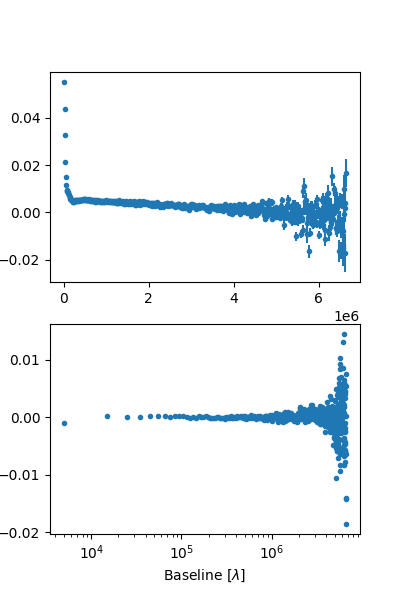

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(4,6))
vis.plot_uvprofile(axes=axes, fmt="o", markersize=3)
axes[0].set(xscale="linear")


In [19]:
vis.bin_2D(binsize=10e3, replace=True)
print(vis.V.shape)
vis.export_vis(filename="./L1489IRS_continuum_bin10k_test.npz")

/home/yamato/Project/eDisk/firstlook_L1489IRS/visibility.py:54: RuntimeWarning: invalid value encountered in divide
  return vw / w


(2108304,)


In [10]:
vis.V.shape

(2108304,)

In [14]:
400*400

160000

In [28]:
import numpy as np

n = vis.V.size
n * np.log10(n) / (16488914 * np.log10(16488914))


30.02931876685333

In [4]:
# vis.bin_2D(binsize=10e3)
vis.export_vis(filename="./L1489IRS_continuum_shift.bin_30s.split.npz")


In [23]:
vis.deproject(PA=PA, incl=incl)
r, v, err = vis.bin_1D(binsize=10e3)


(-0.02, 0.06)

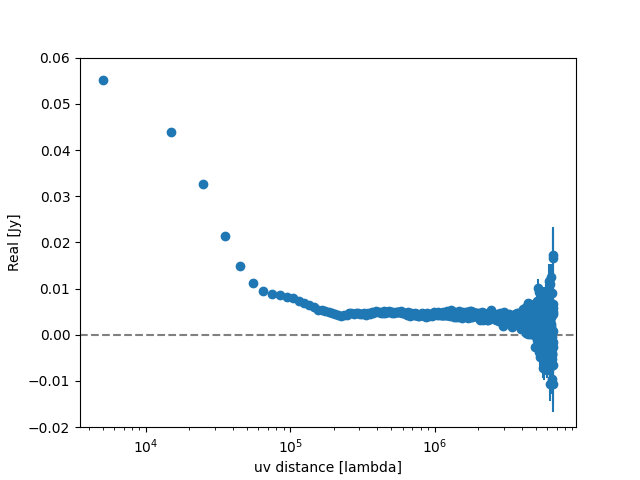

In [26]:
plt.figure()
plt.errorbar(r, v.real, yerr=err, fmt="o")
plt.axhline(y=0.0, color="grey", ls="dashed")
plt.xscale("log")
plt.xlabel("uv distance [lambda]")
plt.ylabel("Real [Jy]")
plt.ylim(-0.02, 0.06)


In [20]:
binvis = Visibility("./L1489IRS_continuum_bin10k_test.npz")
print(binvis.V.size)
binvis.deproject(PA=PA, incl=incl)
rbin, vbin, errbin = binvis.bin_1D(binsize=10e3)


2108304


/home/yamato/Project/eDisk/firstlook_L1489IRS/visibility.py:36: RuntimeWarning: invalid value encountered in divide
  return vw / w
/home/yamato/Project/eDisk/firstlook_L1489IRS/visibility.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  return 1. / np.sqrt(np.nansum(x))


(-0.02, 0.06)

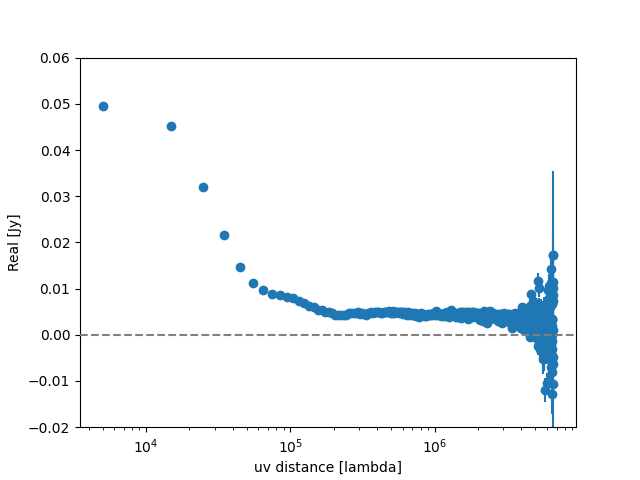

In [30]:
plt.figure()
plt.errorbar(rbin, vbin.real, yerr=errbin, fmt="o")
plt.axhline(y=0.00, color="grey", ls="dashed", zorder=100)
plt.xscale("log")
plt.xlabel("uv distance [lambda]")
plt.ylabel("Real [Jy]")
plt.ylim(-0.02, 0.06)

In [20]:
import numpy as np

np.max(vis.uvdist)


2130739.7605331475

In [12]:
ms.open(vis.filenames[0])
# ms.selectinit(datadescid=0)
ms.getfielddirmeas(format="measure")

metadata = ms.metadata()
metadata.phasecenter()
from astropy.coordinates import SkyCoord
import astropy.units as u

c = SkyCoord(ra=1.06776 * u.rad, dec=0.4592945 * u.rad, frame="icrs")
c.to_string("hmsdms")


'04h04m42.75396789s +26d18m56.29105286s'

In [69]:
ms.open(msfilename)
import numpy as np

ms.selectinit(datadescid=4)
data = ms.getdata(["flag", "data", "weight", "u"])
print(data["weight"].shape)
np.where(data["flag"] == False)


(2, 227010)


(array([0, 0, 0, ..., 1, 1, 1]),
 array([ 0,  0,  0, ..., 63, 63, 63]),
 array([    46,     47,     48, ..., 162147, 162148, 162149]))

In [65]:
ms.getdata(["axis_info"])


{'axis_info': {'corr_axis': array(['XX', 'YY'], dtype='<U16'),
  'freq_axis': {'chan_freq': array([[2.18659277e+11],
          [2.18629980e+11],
          [2.18600683e+11],
          [2.18571386e+11],
          [2.18542089e+11],
          [2.18512792e+11],
          [2.18483496e+11],
          [2.18454199e+11],
          [2.18424902e+11],
          [2.18395605e+11],
          [2.18366308e+11],
          [2.18337011e+11],
          [2.18307714e+11],
          [2.18278417e+11],
          [2.18249121e+11],
          [2.18219824e+11],
          [2.18190527e+11],
          [2.18161230e+11],
          [2.18131933e+11],
          [2.18102636e+11],
          [2.18073339e+11],
          [2.18044042e+11],
          [2.18014746e+11],
          [2.17985449e+11],
          [2.17956152e+11],
          [2.17926855e+11],
          [2.17897558e+11],
          [2.17868261e+11],
          [2.17838964e+11],
          [2.17809667e+11],
          [2.17780371e+11],
          [2.17751074e+11],
          [2.17

In [66]:
ms.getspectralwindowinfo()


{'4': {'Chan1Freq': 218659276824.83282,
  'ChanWidth': -29296875.0,
  'Frame': 'TOPO',
  'NumChan': 64,
  'NumCorr': 2,
  'PolId': 0,
  'RefFreq': 216813573699.83282,
  'SpectralWindowId': 4,
  'TotalWidth': 1875000000.0}}

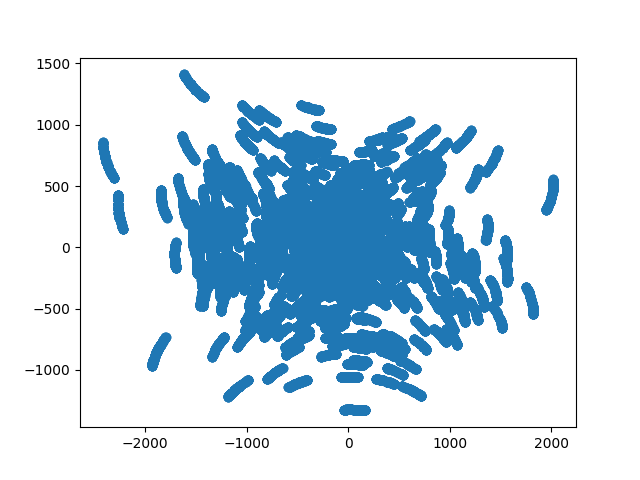

In [19]:
plt.scatter(data["u"], data["v"])
